In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Parameters

In [2]:
# this cell is tagged `parameters` and will be overridden by papermill
sample_name = "1626_BmTreg_HTO"
workflow_id = "36f39f48-0503-4ab7-b8db-f2fd35a7f4fd"
path_data = os.path.join("./data/", sample_name, workflow_id)

## Run Report

In [3]:
!cat $path_data/report/run_report.yaml

Date: 2019-12-09
Running time: 26.0 minutes, 43.34 seconds
CITE-seq-Count Version: 1.4.3
Reads processed: 58448423
Percentage mapped: 96
Percentage unmapped: 4
Uncorrected cells: 157
Correction:
	Cell barcodes collapsing threshold: 1
	Cell barcodes corrected: 113533
	UMI collapsing threshold: 1
	UMIs corrected: 147958
Run parameters:
	Read1_filename: /cromwell_root/dp-lab-batch/cromwell-execution/Sharp/36f39f48-0503-4ab7-b8db-f2fd35a7f4fd/call-TrimR1/R1.fastq.gz
	Read2_filename: /cromwell_root/dp-lab-batch/cromwell-execution/Sharp/36f39f48-0503-4ab7-b8db-f2fd35a7f4fd/call-TrimR2/R2.fastq.gz
	Cell barcode:
		First position: 1
		Last position: 16
	UMI barcode:
		First position: 17
		Last position: 28
	Expected cells: 0
	Tags max errors: 2
	Start trim: 0


## Classification

### Read

In [4]:
df_class = pd.read_csv(
    os.path.join(path_data, "final-classification.tsv.gz"),
    sep="\t",
    compression="gzip",
    index_col=0
)

In [5]:
df_class

,hashID
120703409057195,A0302
120703409315118,A0304
120703409575651,A0303
120703409666781,A0301
120703423999332,A0304
...,...
241184535592158,A0302
241184535632811,Doublet
241184535866796,A0304
241184536151923,A0303


In [6]:
df_class.shape

(9606, 1)

### Numeric to ACGT

In [7]:
from dna3bit import DNA3Bit

In [8]:
dna3bit = DNA3Bit()

In [9]:
new_index = df_class.index.map(lambda x: dna3bit.decode(x).decode())

In [10]:
df_class.index = new_index

In [11]:
df_class

,hashID
TTTATGCTCATCCCGT,A0302
TTTATGCTCGTGCAGC,A0304
TTTATGCTCCTGTTAT,A0303
TTTATGCTCCCTGTTG,A0301
TTTATGCAGGTCCGAA,A0304
...,...
CCCGGAACAATTCTTC,A0302
CCCGGAACAAAGGCGT,Doublet
CCCGGAACAGTCCCGA,A0304
CCCGGAACACAATGCT,A0303


### Results

In [12]:
df_stats = df_class.groupby(by="hashID").size()
df_stats

hashID
A0301      2402
A0302      1474
A0303      2236
A0304      2586
Doublet     908
dtype: int64

In [13]:
df_stats.sum()

9606

In [14]:
# sum excluding doublets
df_stats[ df_stats.index != "Doublet" ].sum()

8698

### Pie Chart

In [15]:
labels = [label.upper() if label != "Doublet" else "Doublet/Negative" for label in df_stats.index]
labels

['A0301', 'A0302', 'A0303', 'A0304', 'Doublet/Negative']

#### Pie 1

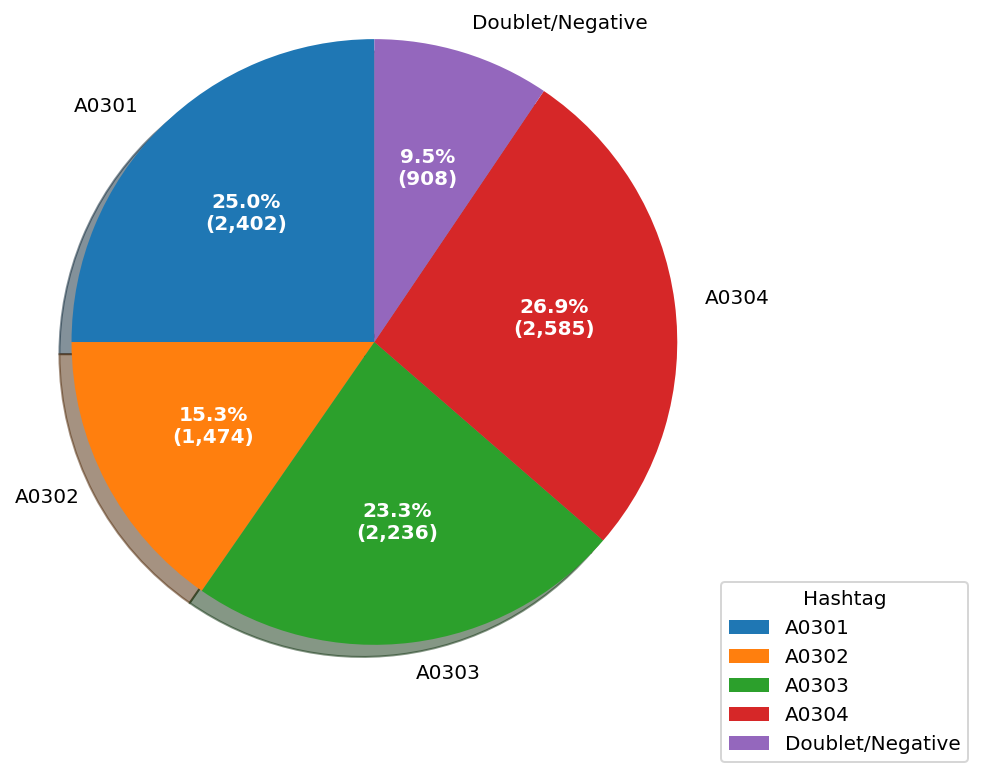

In [16]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

def func_autopct(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,d})".format(pct, absolute)

wedges, _, autotexts = ax.pie(
    df_stats,
    labels=labels,
    autopct=lambda pct: func_autopct(pct, df_stats),    
    shadow=True, startangle=90
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

ax.axis('equal')
ax.legend(
    wedges,
    labels,
    title="Hashtag",
    loc="center left",
    bbox_to_anchor=(1, -0.5, 0.5, 1)
)

plt.show()

#### Pie 2

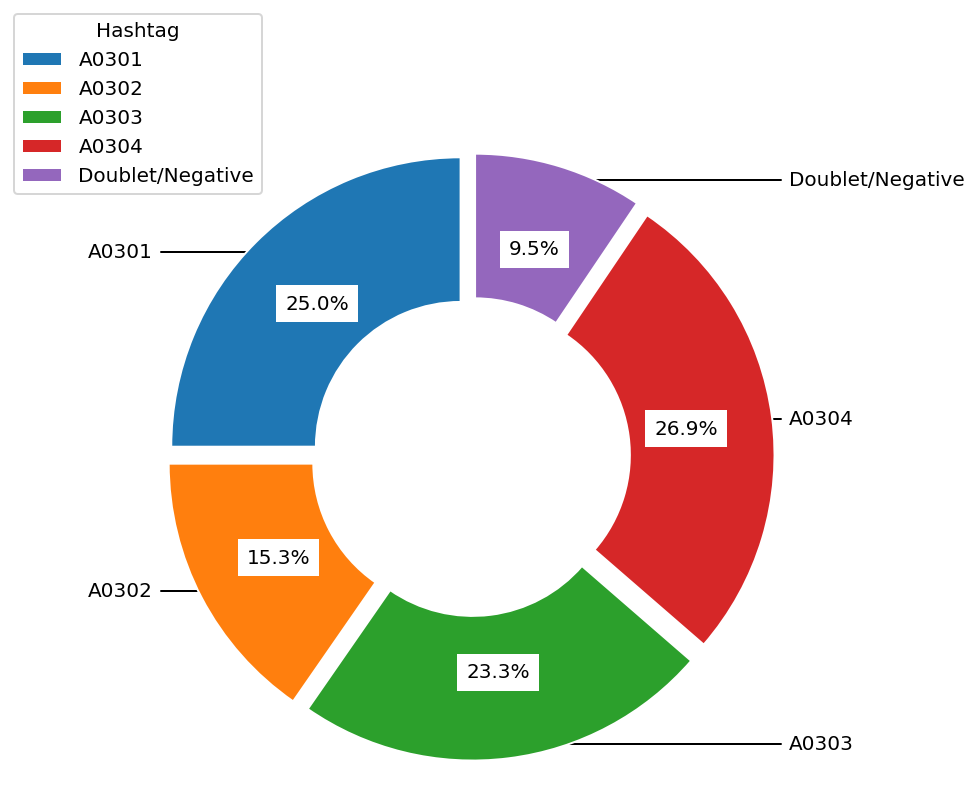

In [17]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

def func_autopct(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:,d})".format(pct, absolute)

cmap = plt.get_cmap("tab20c")

wedges, _, autotexts = ax.pie(
    df_stats,
    explode=[0.05] * len(df_stats),
    wedgeprops=dict(width=0.5, edgecolor='w'),
    autopct='%1.1f%%',
    pctdistance=0.7,
    shadow=False,
    startangle=90,
    rotatelabels=True
)

kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(
        labels[i], xy=(x, y), xytext=(1.1 * np.sign(x), y),
        horizontalalignment=horizontalalignment, **kw
    )

for i, autotext in enumerate(autotexts):
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_rotation(0)
    autotext.set_backgroundcolor("white")
    
ax.axis('equal')
ax.legend(
    wedges,
    labels,
    title="Hashtag",
    bbox_to_anchor=(-0.3, 0.2, 0.5, 1)
)

plt.show()

### Distribution

In [18]:
df_dist = df_stats.drop(labels=["Doublet"])
df_dist

hashID
A0301    2402
A0302    1474
A0303    2236
A0304    2586
dtype: int64

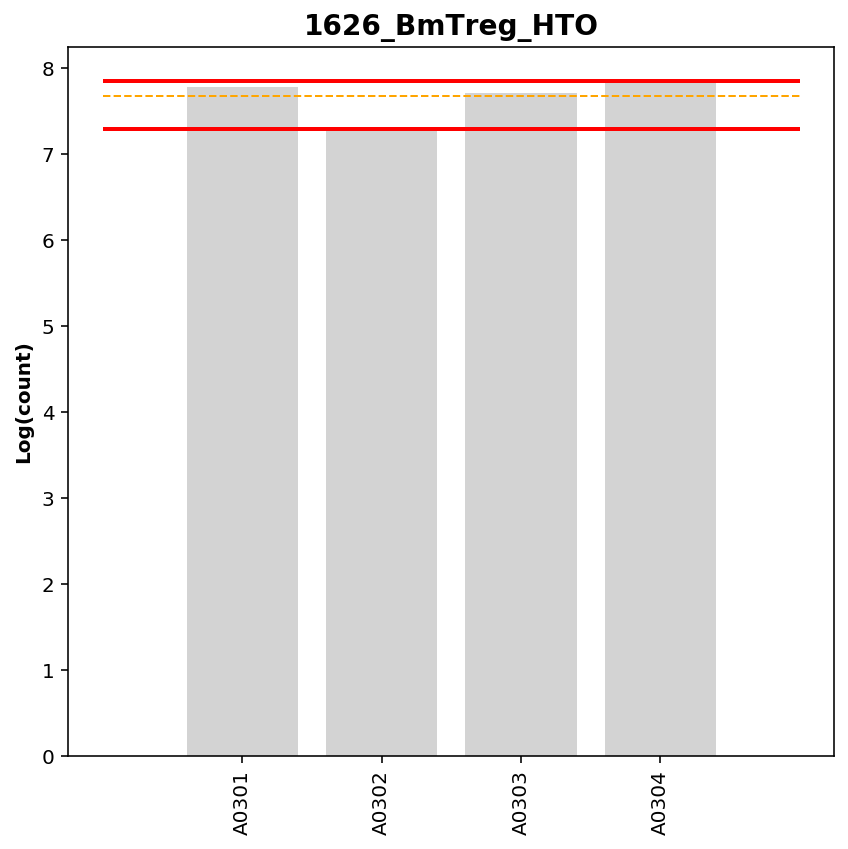

In [19]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

ax.bar(df_dist.index, np.log(list(df_dist.values)), color="lightgray")
    
ax.set_ylabel("Log(count)", fontweight="bold")
ax.set_title(sample_name, fontsize=14, fontweight="heavy")
ax.tick_params(axis="x", rotation=90)
    
num_hashtags = len(df_dist.values)
ax.hlines(y=np.log(max(df_dist.values)), xmin=-1, xmax=num_hashtags, colors='red', linestyles='-', lw=2)
ax.hlines(y=np.log(min(df_dist.values)), xmin=-1, xmax=num_hashtags, colors='red', linestyles='-', lw=2)    
ax.hlines(y=np.log(np.mean(list(df_dist.values))), xmin=-1, xmax=num_hashtags, colors='orange', linestyles='--', lw=1)    

plt.tight_layout()

plt.show()

## Reads Count

In [20]:
import numpy as np
import scipy.io

In [21]:
mtx = scipy.io.mmread(
    os.path.join(path_data, "reads/matrix.mtx.gz")
)

In [22]:
barcodes = pd.read_csv(
    os.path.join(path_data, "reads/barcodes.tsv.gz"),
    sep="\t", 
    compression="gzip",
    header=None
)

In [23]:
features = pd.read_csv(
    os.path.join(path_data, "reads/features.tsv.gz"),
    sep="\t",
    compression="gzip",
    header=None
)

In [24]:
df_reads = pd.DataFrame(
    mtx.T.todense(),
    index=barcodes[0],
    columns=features[0]
)

In [25]:
df_reads

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped
0,,,,,
ATCACTTAGTGAACAT,721,25,33,7,65
CTCCAACGTGGTCCCA,19,14,39,696,12
ACAGGGACAGTCGTTA,14,11,36,506,17
AGCGTCGTCCCATTTA,154,9,6,1,11
ATGGAGGGTACTCCGG,594,38,37,9,50
...,...,...,...,...,...
TCTCACGTCGCTACGG,641,18,36,190,74
TGCTCGTCAGTTGAAA,15,582,62,14,19
GTTAGACGTCGACTGC,38,21,35,405,9


### Total Counts per Hashtag

In [26]:
df_reads.sum()

0
A0301-ACCCACCAGTAAGAC    2939722
A0302-GGTCGAGAGCATTCA    6645954
A0303-CTTGCCGCATGTCAT    3731985
A0304-AAAGCATTCTTCACG    2611315
unmapped                  662925
dtype: int64

### Total Counts per Celluar Barcode

In [27]:
df_reads.sum(axis=1)

0
ATCACTTAGTGAACAT     851
CTCCAACGTGGTCCCA     780
ACAGGGACAGTCGTTA     584
AGCGTCGTCCCATTTA     181
ATGGAGGGTACTCCGG     728
                    ... 
TCTCACGTCGCTACGG     959
TGCTCGTCAGTTGAAA     692
GTTAGACGTCGACTGC     508
CCACGTTCAGGCAATG    1334
GCAACATAGTGACACG    1521
Length: 9606, dtype: int64

### First Hashtag

In [28]:
# remove "Doublet" and pick the first hashtag
hashtags = list(set(df_class.hashID.unique()) - set(["Doublet"]))
first_hashtag = hashtags[0] if len(hashtags) > 0 else None
first_hashtag

'A0301'

In [29]:
df_reads.loc[ df_class[ df_class.hashID == first_hashtag ].index ].sort_values(by=df_reads.columns[0], ascending=False)

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped
ATCGTGACACCTGCGA,52423,43,53,33,2760
TCGTCCAAGCTAAACA,32960,27,39,948,2109
GTCATGAGTGTAAATG,29492,34,36,30,1738
CAACAGTGTGTCCACG,28719,36,54,46,1900
TGTTGGACAATTCTTC,26692,48,64,27,1659
...,...,...,...,...,...
TTTAGTCTCGGTAGGA,67,53,47,32,5
GGCTTGGCACGCCAGT,62,2,0,0,6
CCTAAGATCTGTTCAT,24,1,2,1,0
TCTACATGTAGTTAGA,1,0,0,0,0


### Overall Stats

In [30]:
df_reads.sum(axis=1).sort_values(ascending=False).describe()

count      9606.000000
mean       1727.243494
std        7780.137231
min           0.000000
25%         663.000000
50%         827.000000
75%        1154.000000
max      481551.000000
dtype: float64

### 95 Percentile

In [31]:
percentile_95 = df_reads.sum(axis=1).describe(percentiles=[0.95])["95%"]
percentile_95

4495.0

In [32]:
df_reads[ df_reads.sum(axis=1) > percentile_95 ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped
0,,,,,
AGCTACAGTCGAATTC,72,17943,37,18,960
AAGTACCAGTCGCTAT,60,37,13587,600,583
TTCCGTGGTGAGGCAT,26,69,39,7706,142
CATCGTCGTAGTATAG,3422,161,4486,1211,317
CTTCTCTGTCTTTATC,23244,16,31,43,1505
...,...,...,...,...,...
TACCTGCTCCCATAAG,42,8381,43,8,291
TGGTACATCTGGAGAG,2352,107,1952,366,160
CCACCATGTCTTGTCC,109,26666,13,20,688


In [33]:
df_reads[ df_reads.sum(axis=1) > percentile_95 ].sample(5, random_state=0)

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped
0,,,,,
GCGAGAATCCCGAGGT,22,89,27397,164,795
CAGCAATAGGTTCTAC,104,23105,681,25,800
TTGTTGTCAGAACTCT,90,21981,29,18,562
GTCATGAGTCCAGAAG,39,71,23302,68,739
GTTACCCCACAAAGCG,16,44,36,7655,183


In [34]:
df_reads[ df_reads.sum(axis=1) > percentile_95 ].sample(5, random_state=0).sum(axis=1)

0
GCGAGAATCCCGAGGT    28467
CAGCAATAGGTTCTAC    24715
TTGTTGTCAGAACTCT    22680
GTCATGAGTCCAGAAG    24219
GTTACCCCACAAAGCG     7934
dtype: int64

### Histogram (sum of reads across hashtags)

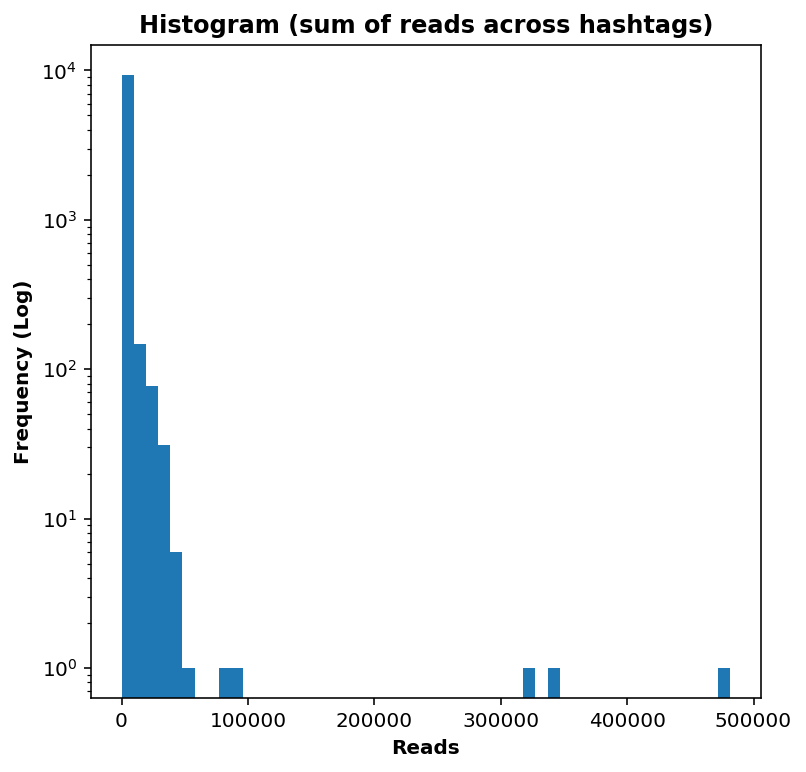

In [35]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

ax.hist(df_reads.sum(axis=1).sort_values(ascending=False), bins=50)

ax.set_xlabel("Reads", fontweight="bold")
ax.set_ylabel("Frequency (Log)", fontweight="bold")
ax.set_title("Histogram (sum of reads across hashtags)", fontweight="bold")

plt.yscale("log")
plt.show()

### Histogram (sum of reads per hashtag)

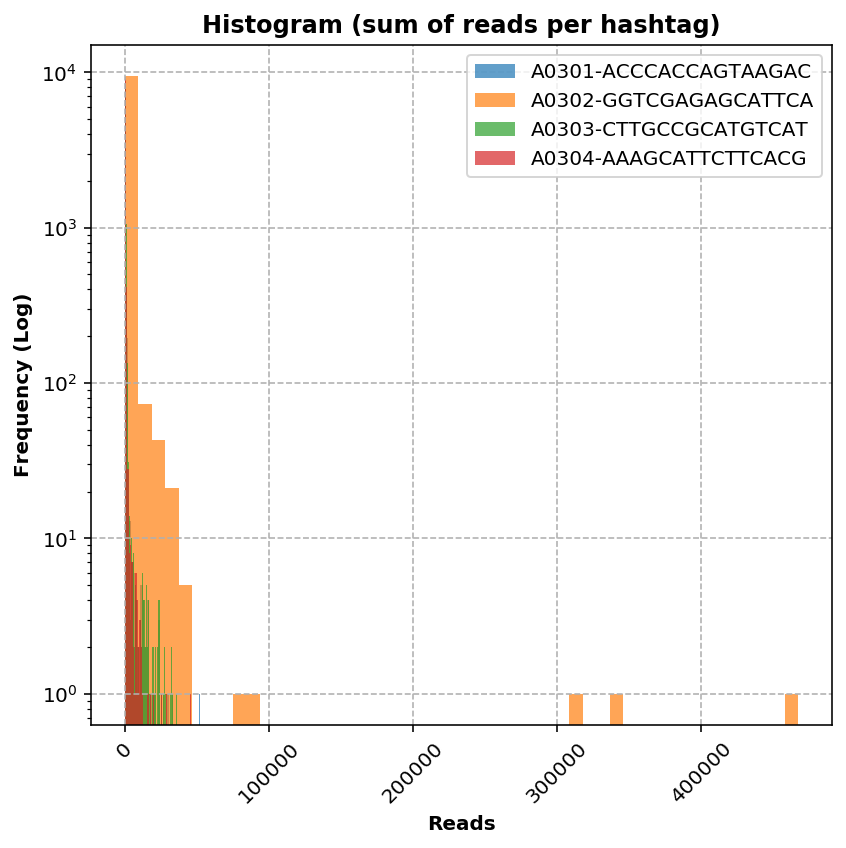

In [36]:
fig = plt.figure(figsize=(6, 6), facecolor="white")

ax = fig.add_subplot(111)
    
for idx, col in enumerate(df_reads.columns[:-1]):
    
    df_tmp = df_reads.iloc[:,idx].sort_values(ascending=False)

    ax.hist(df_tmp, bins=50, alpha=0.7, label=col)

ax.set_xlabel("Reads", fontweight="bold")
ax.set_ylabel("Frequency (Log)", fontweight="bold")
ax.tick_params(axis="x", rotation=45)
ax.set_title("Histogram (sum of reads per hashtag)", fontweight="bold")
ax.grid(b=True, linestyle="--")
ax.legend()

plt.yscale("log")
plt.tight_layout()
plt.show()

### Unmapped

In [37]:
df_reads.sort_values(by="unmapped", ascending=False).iloc[:,-1]

0
CATCAAGCACCAATTG    11386
GAGGGATTCATTGCCC     6767
GTGAGTTGTGGAAGTC     6143
GGAACCCTCTCCTGAC     3135
ATCGTGACACCTGCGA     2760
                    ...  
CTCAGTCAGCAAACAT        0
GTTTACTCACGTAGTT        0
AAGACAACACTGATTG        0
TGGTTAGGTCCAGCAC        0
TGCGGGTTCCGGTTCT        0
Name: unmapped, Length: 9606, dtype: int64

## UMI Count

In [38]:
mtx = scipy.io.mmread(
    os.path.join(path_data, "umis/matrix.mtx.gz")
)

In [39]:
barcodes = pd.read_csv(
    os.path.join(path_data, "umis/barcodes.tsv.gz"),
    sep="\t", 
    compression="gzip",
    header=None
)

In [40]:
features = pd.read_csv(
    os.path.join(path_data, "umis/features.tsv.gz"),
    sep="\t",
    compression="gzip",
    header=None
)

In [41]:
df_umis = pd.DataFrame(
    mtx.T.todense(),
    index=barcodes[0],
    columns=features[0]
)

In [42]:
df_umis

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped
0,,,,,
ATCACTTAGTGAACAT,345,10,16,4,26
CTCCAACGTGGTCCCA,12,11,17,382,6
ACAGGGACAGTCGTTA,9,7,20,260,9
AGCGTCGTCCCATTTA,96,5,6,1,8
ATGGAGGGTACTCCGG,301,12,23,5,18
...,...,...,...,...,...
TCTCACGTCGCTACGG,326,10,19,97,26
TGCTCGTCAGTTGAAA,8,277,33,5,10
GTTAGACGTCGACTGC,19,9,18,211,6


## Reads per UMI

### Calculate

In [43]:
# reads divided by UMI, replace NaN with zero
df_reads_per_umi = (df_reads / df_umis).replace(to_replace=np.NaN, value=0)
# remove the "unmapped" column
df_reads_per_umi = df_reads_per_umi.iloc[:,0:-1]
df_reads_per_umi

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG
0,,,,
ATCACTTAGTGAACAT,2.089855,2.500000,2.062500,1.750000
CTCCAACGTGGTCCCA,1.583333,1.272727,2.294118,1.821990
ACAGGGACAGTCGTTA,1.555556,1.571429,1.800000,1.946154
AGCGTCGTCCCATTTA,1.604167,1.800000,1.000000,1.000000
ATGGAGGGTACTCCGG,1.973422,3.166667,1.608696,1.800000
...,...,...,...,...
TCTCACGTCGCTACGG,1.966258,1.800000,1.894737,1.958763
TGCTCGTCAGTTGAAA,1.875000,2.101083,1.878788,2.800000
GTTAGACGTCGACTGC,2.000000,2.333333,1.944444,1.919431


In [44]:
sum_umis = df_umis.sum(axis=1).sum()
sum_reads = df_reads.sum(axis=1).sum()

In [45]:
reads_per_umi = sum_reads / sum_umis
reads_per_umi

2.0284608496895675

### Histogram

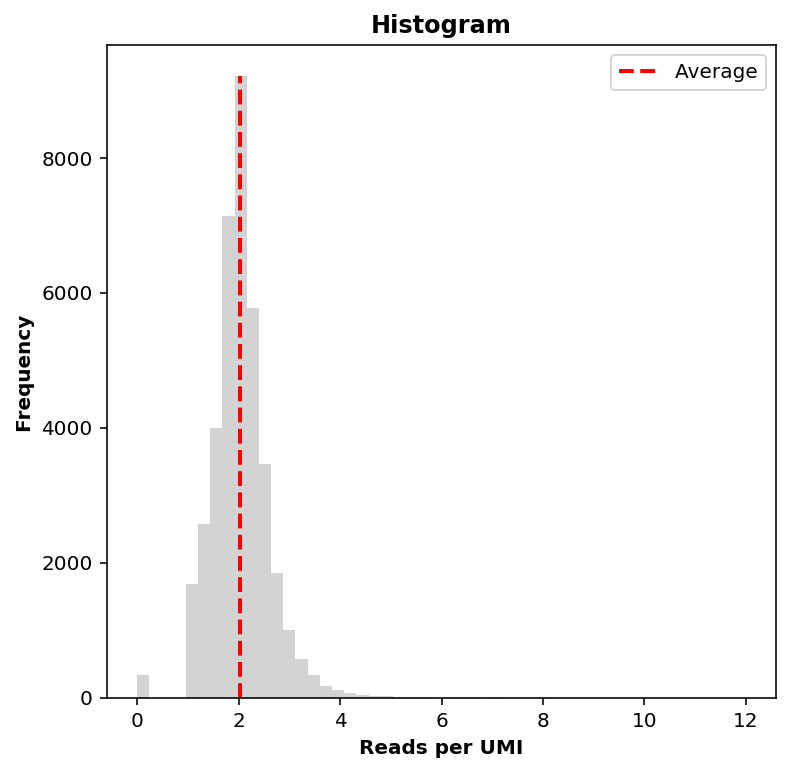

In [46]:
fig = plt.figure(figsize=(6,6), facecolor="white")
ax = fig.add_subplot(111)

n, bins, _ = ax.hist(np.ravel(df_reads_per_umi.values), bins=50, color="lightgray")
ax.vlines(x=reads_per_umi, ymin=0, ymax=np.max(n), color="red", linestyle="--", lw=2, label="Average")

ax.set_xlabel("Reads per UMI", fontweight="bold")
ax.set_ylabel("Frequency", fontweight="bold")
ax.set_title("Histogram", fontweight="bold")
ax.legend()

plt.show()

## Merge (UMI + Class)

In [47]:
df_umi_class = pd.merge(
    df_umis, df_class,
    left_index=True, right_index=True,
    how="inner"
)

In [48]:
df_umi_class

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped,hashID
ATCACTTAGTGAACAT,345,10,16,4,26,A0301
CTCCAACGTGGTCCCA,12,11,17,382,6,A0304
ACAGGGACAGTCGTTA,9,7,20,260,9,A0304
AGCGTCGTCCCATTTA,96,5,6,1,8,A0301
ATGGAGGGTACTCCGG,301,12,23,5,18,A0301
...,...,...,...,...,...,...
TCTCACGTCGCTACGG,326,10,19,97,26,Doublet
TGCTCGTCAGTTGAAA,8,277,33,5,10,A0302
GTTAGACGTCGACTGC,19,9,18,211,6,A0304
CCACGTTCAGGCAATG,7,11,207,402,25,Doublet


## UMI (one vs. rest)

- Ideally, the winning one shouldn't be winning by having less than e.g. 10 UMIs?
- Ideally, the losing ones should have UMIs close to zero.

### All

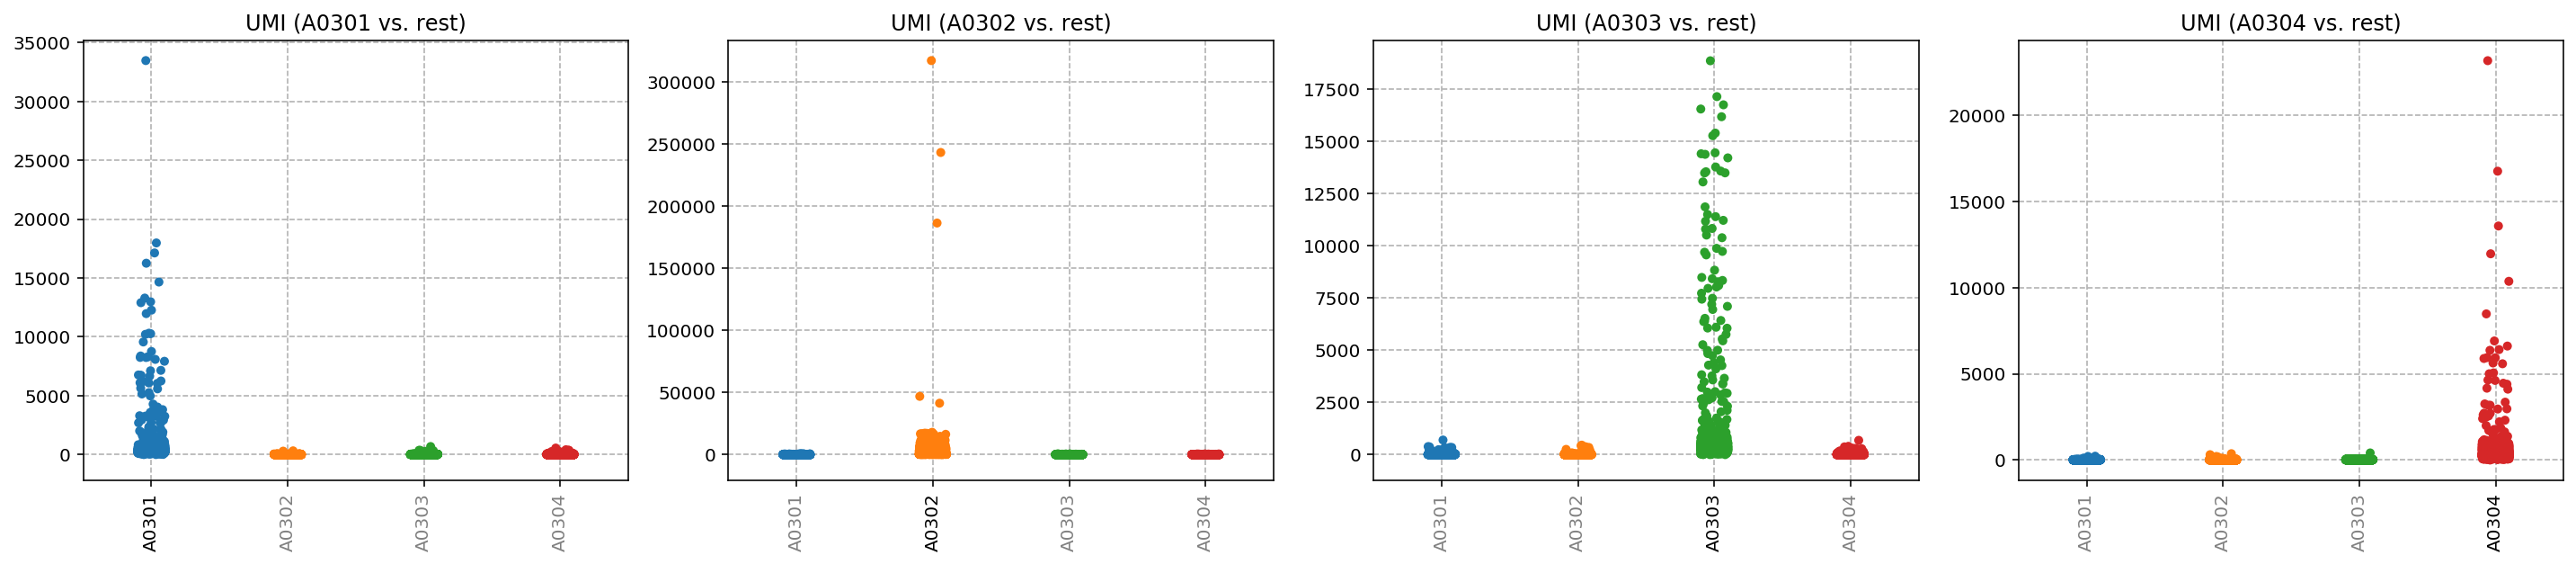

In [49]:
num_hashtags = len(df_umi_class.columns[:-2])
num_cols = 4
num_rows = num_hashtags / num_cols + 1

fig = plt.figure(figsize=(20, num_rows * 4), facecolor="white")

idx_plot = 0

for hashtag in sorted(hashtags):
    
    idx_plot += 1
    
    ax = fig.add_subplot(num_rows, num_cols, idx_plot)

    df_tmp = df_umi_class[ df_umi_class.hashID == hashtag ].iloc[:,0:-2]
    df_tmp.columns = list(map(lambda col: col.split("-")[0], df_tmp.columns))

    sns.stripplot(data=df_tmp, ax=ax)

    ax.set_title(f"UMI ({hashtag} vs. rest)")
    ax.tick_params(axis="x", rotation=90)
    ax.grid(b=True, linestyle="--")
#     ax.set_yscale("log")
    
    for tick in ax.xaxis.get_major_ticks():
        if tick.label.get_text() == hashtag:
            tick.label.set_color("black")
        else:
            tick.label.set_color("gray")

plt.tight_layout()
plt.show()

### 25th Percentile

In [50]:
umi_sum_percentile_25 = df_umi_class.iloc[:,0:-2].sum(axis=1).describe()["25%"]
umi_sum_percentile_25

309.0

In [51]:
df_umi_class[ (df_umi_class.iloc[:,0:-2].sum(axis=1) < umi_sum_percentile_25) & (df_umi_class.hashID != "Doublet") ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped,hashID
ACAGGGACAGTCGTTA,9,7,20,260,9,A0304
AGCGTCGTCCCATTTA,96,5,6,1,8,A0301
TATCTTGGTATGAAGT,6,2,0,68,0,A0304
CCTATCGCATCCTATT,13,5,19,245,8,A0304
GATCATGTCATTCGTT,8,1,6,119,0,A0304
...,...,...,...,...,...,...
TGCCGAGCATCACCAA,196,13,19,16,7,A0301
AAATGGACATCCCACT,252,9,18,6,27,A0301
TTGAACGTCACCTTGC,16,5,19,263,10,A0304
TTTCGATTCTCACTCG,215,7,12,6,11,A0301


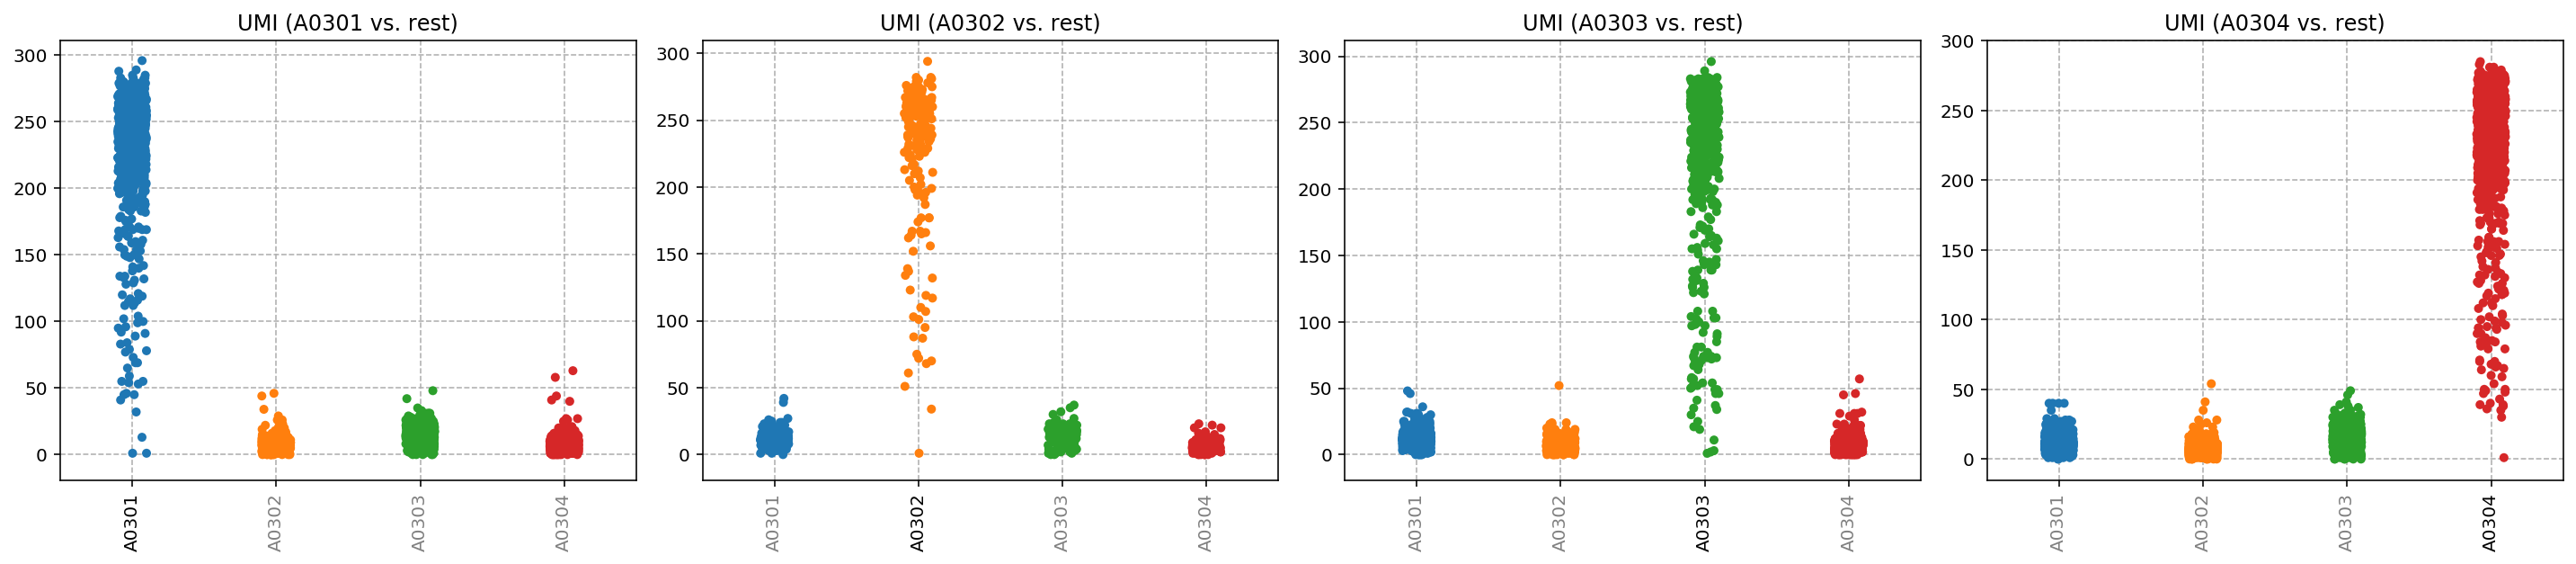

In [52]:
num_hashtags = len(df_umi_class.columns[:-2])
num_cols = 4
num_rows = num_hashtags / num_cols + 1

fig = plt.figure(figsize=(20, num_rows * 4), facecolor="white")

idx_plot = 0

for hashtag in sorted(hashtags):
    
    idx_plot += 1
    
    ax = fig.add_subplot(num_rows, num_cols, idx_plot)

    df_tmp = df_umi_class[ (df_umi_class.iloc[:,0:-2].sum(axis=1) < umi_sum_percentile_25) & (df_umi_class.hashID == hashtag) ].iloc[:,0:-2]
    df_tmp.columns = list(map(lambda col: col.split("-")[0], df_tmp.columns))

    sns.stripplot(data=df_tmp, ax=ax)

    ax.set_title(f"UMI ({hashtag} vs. rest)")
    ax.tick_params(axis="x", rotation=90)
    ax.grid(b=True, linestyle="--")
    
    for tick in ax.xaxis.get_major_ticks():
        if tick.label.get_text() == hashtag:
            tick.label.set_color("black")
        else:
            tick.label.set_color("gray")

plt.tight_layout()
plt.show()

## UMI Distribution

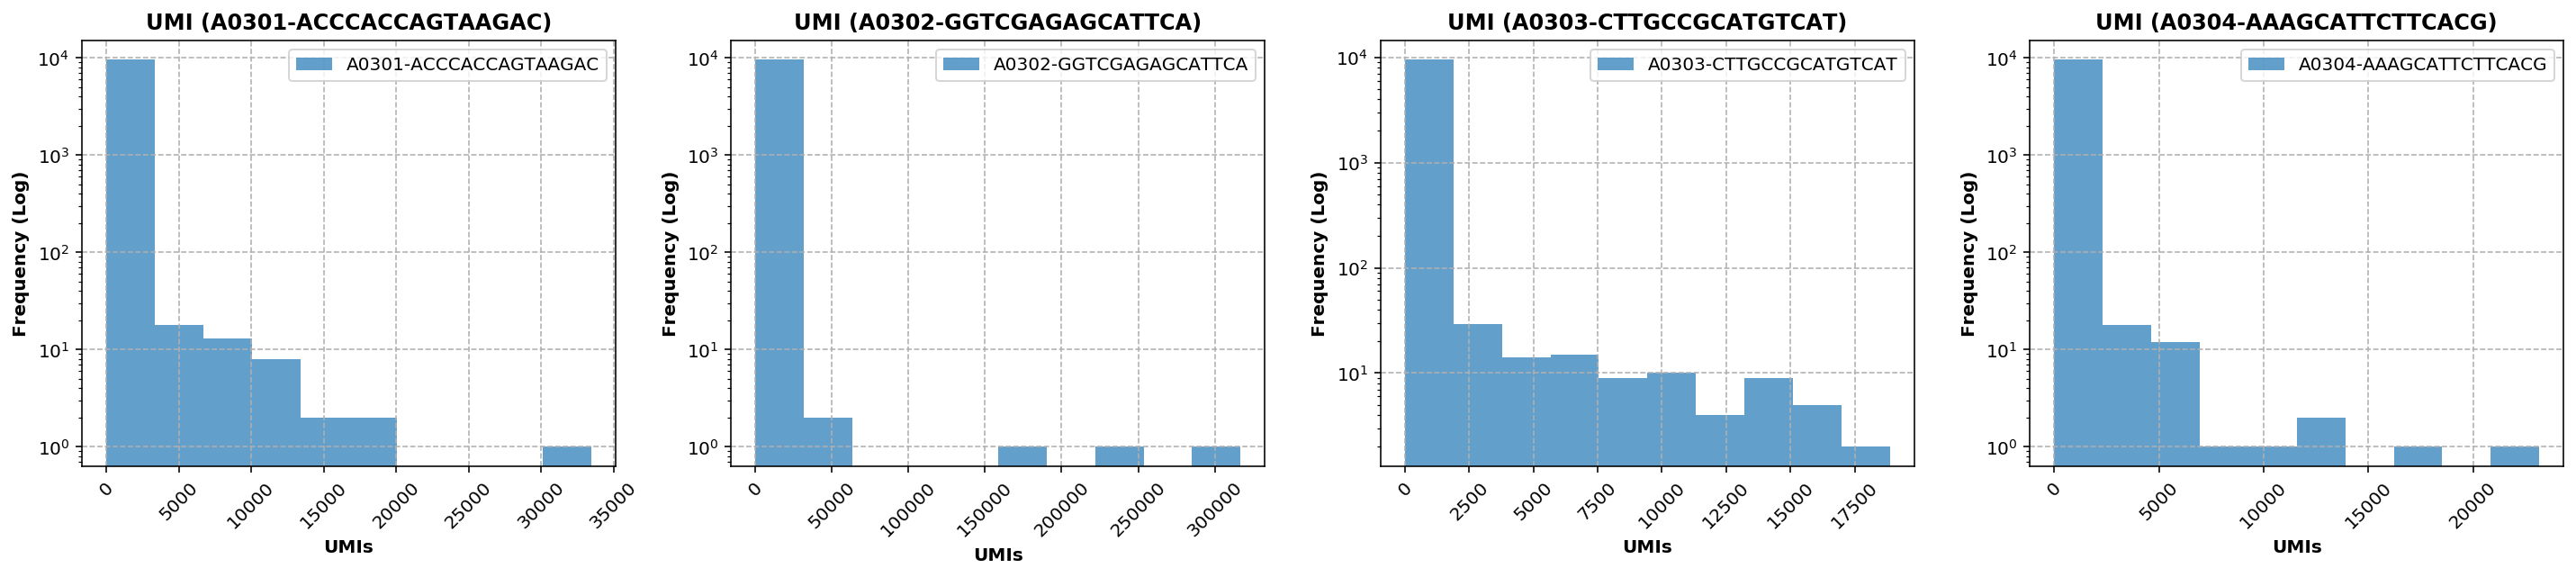

In [53]:
num_hashtags = len(df_umi_class.columns[:-2])
num_cols = 4
num_rows = num_hashtags / num_cols + 1

fig = plt.figure(figsize=(20, num_rows * 4), facecolor="white")

idx_plot = 0

for idx, col in enumerate(df_umi_class.columns[:-2]):

    idx_plot += 1
    ax = fig.add_subplot(num_rows, num_cols, idx_plot)
    
    df_tmp = df_umi_class.iloc[:,idx].sort_values(ascending=False)

    ax.hist(df_tmp, bins=10, alpha=0.7, label=col)

    ax.set_xlabel("UMIs", fontweight="bold")
    ax.set_ylabel("Frequency (Log)", fontweight="bold")
    ax.tick_params(axis="x", rotation=45)
    ax.set_title(f"UMI ({col})", fontweight="bold")
    ax.grid(b=True, linestyle="--")
    ax.set_yscale("log")
    ax.legend()

plt.tight_layout()
plt.show()

## Doublets

In [54]:
df_umi_class[ df_umi_class.hashID == "Doublet" ]

,A0301-ACCCACCAGTAAGAC,A0302-GGTCGAGAGCATTCA,A0303-CTTGCCGCATGTCAT,A0304-AAAGCATTCTTCACG,unmapped,hashID
CTGAGGCCAAGTCGTT,14,396,15,320,31,Doublet
AATTCCTTCGCCACTT,9,5,276,611,21,Doublet
TATCTTGGTAGCTGAG,398,8,411,9,39,Doublet
CACCAAAGTTCAGGTT,11,9,429,250,27,Doublet
CGACAGCAGGTTGAGC,7,11,273,283,13,Doublet
...,...,...,...,...,...,...
AATGCCACACACACGC,0,0,0,0,0,Doublet
AACAAGAGTTATGACC,7,377,18,135,23,Doublet
TCTCACGTCGCTACGG,326,10,19,97,26,Doublet
CCACGTTCAGGCAATG,7,11,207,402,25,Doublet
